#Тестовое "Альфа-Банк"##

##Задание 1 - решение задач с использованием SQL##

###Задача 1###
Отобрать клиентов по г. Москва с суммарными остатками по клиенту от 20 000 на
последнюю дату.  
Напишем SQL запрос:

```sql
--Создадим необходимые таблицы.

create table if not exists clients (client_id varchar(1), FIO varchar (255), Region varchar(50), account_num int);
insert into clients values
('A','Иванов','Москва',111),
('A','Иванов','Москва',222),
('B','Петров','Иваново',333),
('C','Сидоров','Москва',444);

create table if not exists accounts ([Date] date, Summa_USD money, Account_num int);
insert into accounts values
('2012-01-01',15000,111),
('2012-02-01',10000,111),
('2012-02-01',5000,222),
('2012-03-01',30000,333),
('2012-04-01',20000,444);

--Выполним запрос, используя группировку.

select client_id, FIO, SUM(Summa_USD) as summa
from accounts a
left join  clients c ON a.Account_num=c.account_num
where region = 'Москва'
group by client_id, FIO
having SUM(Summa_USD) >= 20000
order by client_id, FIO;

--Выполним запрос, используя оконную функцию.

with stats as (
  select client_id,
  FIO,
  c.account_num,
  Date,
  Summa_USD,
  SUM(Summa_USD) over(partition by client_id order by Date) as cum_sum
  from accounts a
  left join  clients c ON a.Account_num=c.account_num
  where region = 'Москва'
  order by client_id, FIO, Date
)
select distinct client_id, FIO, summa
from stats
where summa >= 20000
```

###Задача 2###
Необходимо посчитать кол-во клиентов, у которых баланс на 2023-07-07 больше 500
рублей. IN - приход средств на счет клиента, OUT - отток.  
Напишем SQL запрос:

```sql
--Создадим таблицу.

create table if not exists oper (client varchar, date date, type varchar, amount int);
insert into oper values
('a', '2023-06-02', 'in', 1985),
('a', '2023-06-03', 'in', 1577),
('a', '2023-06-04', 'out', 1597),
('b', '2023-06-05', 'in', 1468),
('c', '2023-07-06', 'in', 582),
('c', '2023-07-08', 'out', 550),
('d', '2023-06-09', 'in', 1556),
('d', '2023-06-10', 'out', 1480);

--Выполним запрос.

with calculate as (
	select
		client,
		sum(case when type = 'in' then amount when type = 'out' then -amount end) as balance
  	from oper
	where date <= '2023-07-07'
	group by client
)
select count(client) as cnt_clients
from calculate
where balance > 500
```

###Задача 3###
Даны данные о действиях клиента в мобильном приложении. Нужно получить для
каждого клиента его первое действие и время этого первого действия.  
Напишем SQL запрос:
```sql
--Создадим таблицу

create table events (client varchar, date date, actions varchar);
insert into events values
('a', '2019-06-02', 'Auth'),
('a', '2019-06-03', 'Pay'),
('a', '2019-06-04', 'Auth'),
('b', '2019-06-05', 'Settings'),
('b', '2019-06-06', 'Error'),
('c', '2019-07-06', 'Chat'),
('c', '2019-07-08', 'Pay');

--Выполним запрос

select client, actions, date
from (select *,
		row_number() over(partition by client order by date) as rn
      	from events) as t
where rn = 1;
```

###Задача 4###
Даны месячные срезы сегментов
клиентов, нужно получить по каждому клиенту периоды действия каждого сегмента.  
Напишем SQL запрос:
```sql
--Создадим таблицу.

create table segment ([date] date, ClientID varchar(6),SegmentID int);
insert into segment values
('2018-01-31' ,'A11111', 2),
('2018-02-28' ,'A11111', 2),
('2018-03-31' ,'A11111', 1),
('2018-04-30' ,'A11111', 2),
('2018-05-31' ,'A11111', 1),
('2017-11-30' ,'B22222', 1),
('2017-10-31' ,'B22222', 1),
('2017-09-30' ,'B22222', 3),
('2017-09-30' ,'C33333', 1),
('2017-10-31' ,'C33333', 1);

--Выполним запрос, используя группировку.

select
    ClientID,
    SegmentID,
    'с ' || MIN(date) || ' по ' || MAX(date) as TimePeriod
from segment
group by ClientID, SegmentID
order by ClientID, SegmentID, TimePeriod

--Выполним запрос, используя оконные функции.

select
	distinct ClientID,
	SegmentID,
    'с ' || first_value(date) over(partition by ClientID, SegmentID order by date) || ' по ' ||
 	last_value(date) over(partition by ClientID, SegmentID order by date
    range between unbounded preceding and unbounded following) as TimePeriod
from segment
```

##Задание 2 - разметка и метрики##

Партнерская витрина - это набор предложений партнеров банка, которые предоставляют различного рода скидки клиентам.  
На витрину можно перейти разными способами: через внешние и внутренние
коммуникации (SMS, email, push, баннеры/уведомления внутри приложения).
Партнеры могут предоставлять данные о совершенных нашими клиентами конверсиях
(транзакциях).  
- Какие наборы метрик для оценки эффективности партнерской витрины вы
можете предложить ?
- Какие из них рекомендуете выбрать как основные, чтобы дать оценку этому
продукту ? И почему ?
- Разметка каких событий вам понадобится ?
- Какую информацию необходимо передавать в событиях ?
- Какие гипотезы мы можем проверить, чтобы улучшить наши основные
показатели ?  


**События на странице с предложениями партнеров:**  

1. Просмотр страницы с предложениями.  
*page - cashback*  
*action - view*  

2. Нажатие на кнопку "назад".  
*page - cashback*  
*block - header*  
*element - button*  
*action - click*  
  
3. Нажатие на категорию кэшбэка в блоке "Популярное"  
*page - cashback*  
*block - popular*  
*element - cashback_button*  
*name - 'Название кнопки'*  
*action - click*  

**События на странице с описанием предложения:**  

1. Просмотр страницы с предложениями.  
*page - restorans*  
*action - view*  

2. Нажатие на кнопку "закрыть".  
*page - restorans*  
*block - header*  
*element - close_button*  
*action - click*  
  
3. Нажатие на ссылку для перехода на сайт партнера  
*page - restorans*  
*block - description*  
*element - href*    
*action - click*  

4. Нажатие на кнопку "перейти к покупкам".  
*page - restorans*  
*block - footer*  
*element - purchase_button*  
*action - click*

Важно также регистроировать когда событие произошло, каким пользователем и из какого источника (органический или реклама).  

**Набор метрик для оценки эффективности**  

*CTR* - для оценки кликабельности на предложения партнеров.  
*CR* - переход к покупке (конверсия в покупку).  
*Глубина просмотра* - позволит оценить заинтересованность аудитории в материалах сайта, их релевантности запросам пользователей.  
*Retention* - удержание пользователей в нашей экосистеме.  
*ARPPU* - показывает средний доход от одного платящего пользователя за определённый период времени.  

**Гипотезы**

- Регулирование количества шагов в воронке до совершения покупки. Будет понимание на каком этапе возникают сложности и отваливается большое кол-во клиентов.  
- Правильность расположения кнопки "Перейти к покупкам" для повышения CR.  
- Проверить какие сроки действия акций партнеров лучше влияют на удержание пользователей.


##Задание 3 - когортный анализ##

В датасете хранятся данные об активности клиентов с сентября 2021 года
по февраль 2022. Необходимо на основе этих данных провести когортный анализ.  

Описание полей:  
CLIENT_ID - идентификатор клиента;  
VALUE_DAY - дата авторизации в мобильное приложение за последние 30 дней;  

- Постройте визуальное представление когорты по месяцам, которая покажет, как
удерживаются клиенты после их первого посещения мобильного приложения;
- Какие гипотезы такого поведения можно предположить? Как их можно
проверить?
- Какими способами можно улучшить ситуацию?

In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dataset.csv', sep=';', index_col=0)
df.head()

,CLIENT_ID,VALUE_DAY
0,3596869440,30.09.2021
1,181778433,30.09.2021
2,4271531990,30.09.2021
3,3949165697,30.09.2021
4,1926920317,30.09.2021


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805821 entries, 0 to 805820
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   CLIENT_ID  805821 non-null  int64 
 1   VALUE_DAY  805821 non-null  object
dtypes: int64(1), object(1)
memory usage: 18.4+ MB


In [4]:
df.columns = ['client_id', 'value_month']

# Преобразуем в формат даты и выделим месяц
df['value_month'] = pd.to_datetime(df['value_month']).dt.to_period('M')

# Определим когорты для каждого клиента
df['cohort'] = df.groupby('client_id')['value_month'].transform('min')

# Выделим месяц визита в приложение
df['visit_num'] = (df['value_month'] - df['cohort']).apply(lambda x: x.n)

# Преобразуем формат столбца с когортами
df['cohort'] = df['cohort'].dt.strftime('%Y-%m')

/tmp/ipython-input-4-3731172079.py:4: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['value_month'] = pd.to_datetime(df['value_month']).dt.to_period('M')


In [5]:
# Сгруппируем данные и определим кол-во уникальных клиентов в каждом месяце
groupped_data = df.groupby(['cohort', 'visit_num'], as_index=False)['client_id'].nunique()

# Составим сводную таблицу
cohort = groupped_data.pivot(index='cohort', columns='visit_num', values='client_id')

# В каждом столбце разделим кол-во клиентов в текущем месяце на кол-во клиентов в месяц регистрации
divider = cohort.iloc[:,0]
cohort = cohort.div(divider, axis=0)
cohort

visit_num,0,1,2,3,4,5
cohort,,,,,,
2021-09,1.0,0.964103,0.930358,0.901139,0.816725,0.806016
2021-10,1.0,0.984668,0.977144,0.715503,0.681431,NaN
2021-11,1.0,0.983222,0.894539,0.749358,NaN,NaN
2021-12,1.0,0.900073,0.897455,NaN,NaN,NaN
2022-01,1.0,0.973189,NaN,NaN,NaN,NaN
2022-02,1.0,NaN,NaN,NaN,NaN,NaN


**Визуализируем с помощью библиотеки Plotly**

In [6]:
fig = px.imshow(
   cohort,
   labels={'x': 'Месяц визита', 'y': 'Когорта', 'color': 'Удержание, %'},
   title='Когортный анализ',
   color_continuous_scale='RdYlGn',
   color_continuous_midpoint=0.5,
   text_auto=True,
   zmin=0,
   zmax=1,
   aspect='auto'
)

text_values = cohort.map(lambda x: f"{x:.2f}")


fig.update_traces(
   text=text_values.values,
   texttemplate="%{text}",
   hovertemplate=(
       "Когорта: %{y}<br>"
       "Месяц визита: %{x}<br>"
       "Удержание: %{z:.2f}<extra></extra>"
   )
)

fig.update_layout(
   autosize=True,
   margin=dict(l=20, r=20, t=50, b=20),
   coloraxis_colorbar=dict(
       title="Удержание"
       #ticksuffix="%"
   ),
   font=dict(size=12),
   height=max(600, len(cohort) * 30 + 100)
)


config = {
   'responsive': True,
   'displayModeBar': True,
   'scrollZoom': True
}
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


**Визуализируем с помощью библиотеки Seaborn**

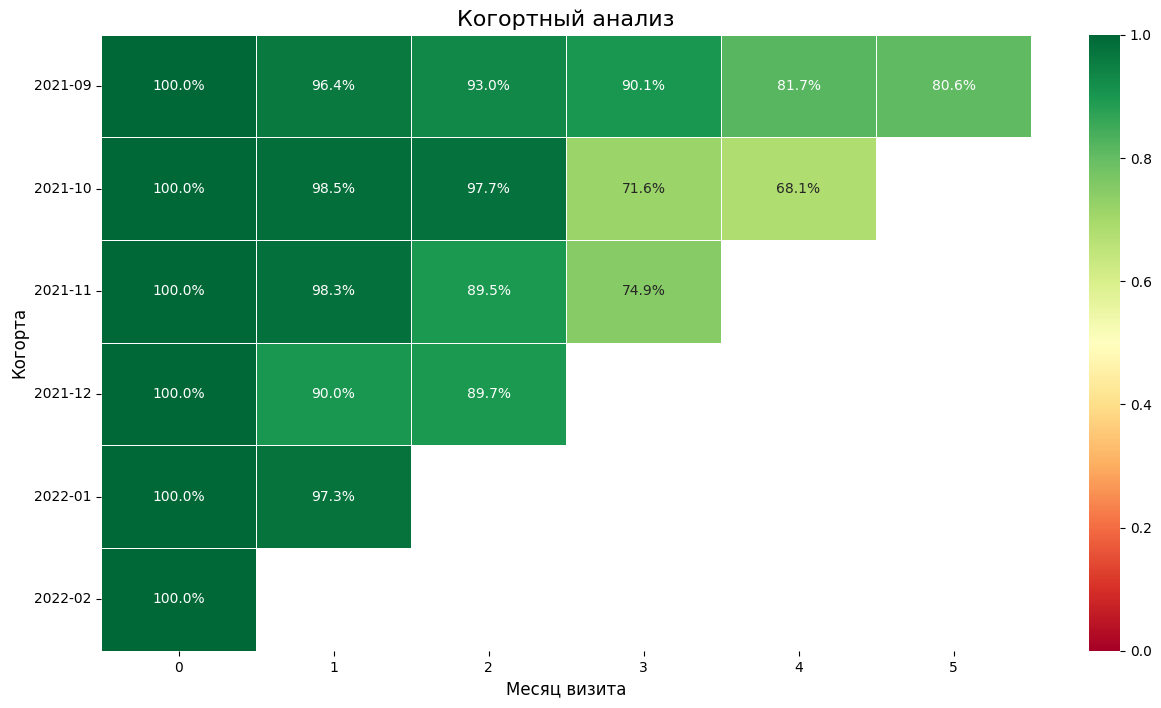

In [7]:
plt.figure(figsize=(15, 8))

sns.heatmap(
    cohort,
    vmin=0, vmax=1, center=0.5,
    linewidth = 0.5,
    cmap='RdYlGn',
    annot=True, fmt='.1%',
    cbar=True,
    cbar_kws={'shrink': 1, 'location':'right'}
)

plt.title('Когортный анализ', fontsize=16)
plt.xlabel('Месяц визита', fontsize=12)
plt.ylabel('Когорта', fontsize=12)
plt.yticks(rotation=0)

plt.show()

**Выводы**  

Перед началом анализа необходимо удостовериться в корректности имеющихся данных, чтобы полученные выводы были правильными и могли быть применены на практике. В данном случае, так как у нас тестовое задание, будем считать, что предоставленные данные корректны.  

По имеющимся данным более правильно будет оценить только первые три когорты (сентябрь, октябрь и ноябрь 2021 г.). Выгодно отличается сентябрьская когорта, с хорошим удержанием на протяжении всего имеющегося периода. Скорее всего, привлечь таких клиентов помог сезонный фактор, так как лето уже закончилось, и людям захотелось сформировать свой досуг на новый рабочий сезон. Люди предложения оценили и продолжают ими пользоваться. Интереса клиентов октябрьской и ноябрьской когорт хватило только на два последующих месяца, а дальше заметен значитильный спад их активности. Можно попробовать исправить ситуацию реактивирующими рассылками. В которых заинтересовать клиентов совершенно новыми предложениями, либо предложить повышенный кэшбэк для старых клиентов, но ограниченный по времени для активации.